# Molecular Dynamics Lite workflow
This notebook implements a simple molecular dynamics (MD) workflow to demonstrate [Parsl Python parallel scripting](https://parsl-project.org/) in a Jupyter notebook. This workflow first runs MD simulations in parallel on remote resources and then renders the frames of an animation visualizing the simulation according to the schematic below.

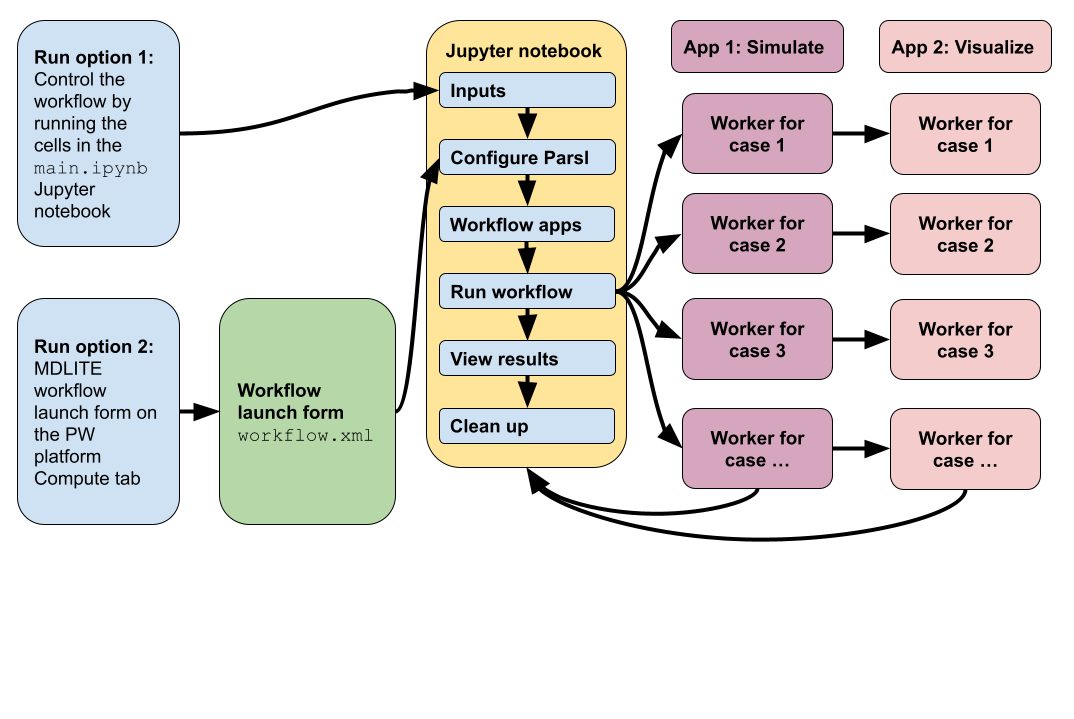

In [1]:
from IPython.display import Image
Image("images/mdlite-parameter-sweep.png")

## Step 1: Define workflow inputs
This PW workflow can be either launched from its form in the `Compute` tab or it can be run directly in this notebook.  If running directly from the notebook, the user needs to go through the extra step of defining the inputs of the workfow in the notebook.

In [ ]:
import os
from os.path import exists

print('Define workflow inputs...')

# Start assuming workflow is launched from the form.
run_in_notebook=False

if (exists("./params.run")):
    print("Running from a PW form.")
    
else:
    print("Running from a notebook.")
    
    # Set flag for later
    run_in_notebook=True
    
    # Manually set workflow inputs here (same as the
    # default values in workflow launch form)
    # The ranges of EACH dimension in the parameter
    # sweep are defined by the format:
    #
    # NAME;input;MIN:MAX:STEP
    #
    #=========================================
    # npart = number of particles
    # steps = time steps in simulation
    # mass = mass of partiles
    # trsnaps = number of frames ("snapshots") of simulation for animation
    #=========================================
    params="npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01:0.02:0.01|trsnaps;input;5:10:5|"
    
    print(params)
    
    # Write to params.run
    with open("params.run","w") as f:
        n_char_written = f.write(params+"\n")

## Step 2: Configure Parsl
The molecular dynamics software itself is a lightweight, precompiled executable written in C. The executable is distributed with this workflow in `./models/mdlite`, and along with input files, it is staged to the remote resources and does not need to be preinstalled.

The core visualization tool used here is a precompiled binary of [c-ray](https://github.com/vkoskiv/c-ray) distributed with this workflow in `./models/c-ray`. The executable is staged to remote resources and does not need to be preinstalled.

In addition to a Miniconda environment containing Parsl, the only other dependency of this workflow is ImageMagick's `convert` tool for image format conversion (`.ppm` to `.png`) and building animated `.gif` files from `.png` frames.

In [ ]:
# Parsl essentials
import parsl
from parsl.app.app import python_app, bash_app
from parsl.data_provider.files import File

# PW essentials
from utils.path import Path
from parslpw import pwconfig,pwargs

# For embedding Design Explorer results in notebook
from IPython.display import display, HTML

# Checking inputs from the WORKFLOW FORM
if (not run_in_notebook):
    print(pwargs)

print("Configuring Parsl...")
parsl.load(pwconfig)
print("pwconfig loaded")

## Step 3: Define Parsl workflow apps
These apps are decorated with Parsl's `@bash_app` and as such are executed in parallel on the compute resources that are defined in the PW configuration loaded above.  Functions that are **not** decorated are not executed in parallel on remote resources. The files that need to be staged to remote resources will be marked with Parsl's `File()` (or its PW extension, `Path()`) in the workflow.

In [ ]:
print("Defining Parsl workflow apps...")

#===================================
# Molecular dynamics simulation app
#===================================
@bash_app
def md_run(stdout='md.run.stdout', stderr='md.run.stderr', inputs=[], outputs=[]):
    return '''
    %s/runMD.sh "%s" metric.out trj.out
    outdir=%s
    mkdir -p $outdir
    mv trj.out $outdir/
    mv metric.out $outdir/
    ''' % (inputs[1],inputs[0],outputs[0])

#===================================
# App to render frames for animation
#===================================
# All frames for a given simulation
# are rendered together.

# This app takes a very simple 
# approach to zero padding by adding 
# integers to 1000.
@bash_app
def md_vis_3(stdout='md.vis.stdout', stderr='md.vis.stderr', inputs=[], outputs=[]):
    return '''
    indir=%s
    outdir=%s
    mkdir -p $outdir
    for (( ff=0; ff<%s; ff++ ))
    do
        frame_num_padded=$((1000+$ff))
        %s/renderframe $indir/trj.out $outdir/f_$frame_num_padded.ppm $ff
    done
    ''' % (inputs[2],outputs[0],inputs[0],inputs[1])

## Step 4: Workflow
This cell executes the workflow itself.

In [ ]:
print("Running workflow...")

#============================================================================
# SETUP PARAMETER SWEEP
#============================================================================
# Generate a case list from params.run (the ranges to parameters to sweep)
os.system("python ./models/mexdex/prepinputs.py params.run cases.list")

# Each line in cases.list is a unique combination of the parameters to sweep.
with open("cases.list","r") as f:
    cases_list = f.readlines()

#============================================================================
# SIMULATE
#============================================================================
# For each line in cases.list, run and visualize a molecular dynamics simulation
# These empty lists will store the futures of Parsl-parallelized apps.
# Use Path for staging because multiple files in ./models/mdlite are needed
# and mutliple files in ./results/case_*/md are sent back to the platform.
md_run_fut = []
for ii, case in enumerate(cases_list):        
    # Run simulation
    md_run_fut.append(md_run(
        inputs=[case,
            Path("./models/mdlite")],
        outputs=[Path("./results/case_"+str(ii)+"/md")]))
    
# Call results for all app futures to require
# execution to wait for all simulations to complete.
for run in md_run_fut:
    run.result()

#============================================================================
# VISUALIZE
#============================================================================
md_vis_fut = []
for ii, case in enumerate(cases_list):
    # Get number of frames to render for this case
    nframe = int(case.split(',')[4])
    
    #=========================================================
    # Render all frames for each case in one app.  This approach
    # reduces the number of SSH connections (e.g. rsync instances) 
    # compared to an app that only renders one frame at a time.
    md_vis_fut.append(md_vis_3(
        inputs=[nframe,
                Path("./models/c-ray"),
                Path("./results/case_"+str(ii)+"/md")],
        outputs=[Path("./results/case_"+str(ii)+"/vis")]))

for vis in md_vis_fut:
    vis.result()
    
# Compile frames into movies locally
for ii, case in enumerate(cases_list):
    os.system("cd ./results/case_"+str(ii)+"/vis; convert -delay 10 *.ppm mdlite.gif")

# Compile movies into Design Explorer results locally
os.system("./models/mexdex/postprocess.sh mdlite_dex.csv mdlite_dex.html ./")

## Step 5: View results
This step is only necessary when running directly in a notebook. The outputs of this workflow are stored in the `results` folder and they can be interactively visualized with the Design Explorer by clicking on `mdlite_dex.html` which uses `mdlite_dex.csv` and the data in the `results` folder. The Design Explorer visualization is automatically embedded below.

In [ ]:
# Modify width and height to display as wanted
from IPython.display import IFrame
def designExplorer(url,height=600):
    return IFrame(url, width=800, height=height)


# Makre sure path to datafile=/pw/workflows/mdlite/mdlite_dex.csv is correct
designExplorer(
    '/preview/DesignExplorer/index.html?datafile=/pw/workflows/mdlite/mdlite_dex.csv&colorby=kinetic',
    height=600)

In [ ]:
#=============================================================
# Alphafold EXAMPLE output: 3D visualization in notebook
#=============================================================
# The images displayed below do NOT come from this simulation
# but they are provided here as an example of a more complex
# workflow. In particular, if an image is selected, the 3D
# radio button can be used to interactively rotate molecules.
from IPython.display import IFrame
def designExplorer(url,height=600):
    return IFrame(url, width=800, height=height)

designExplorer(
    '/preview/DesignExplorer/index.html?datafile=/pw/workflows/mdlite/models/sample_af/sample.csv&colorby=plddt',
    height=600)

## Step 6: Use notebook to interact directly with simulation results
Jupyter notebooks are great because cells can be re-run in isolation as ideas are fine-tuned.  The cell below allows for plotting a new result directly from the simulation outputs; there is no need to re-run the simulation if the plot needs to be modified as the user explores the results.

In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
import glob
import math 
import matplotlib.pyplot as plt

### Load data and compute statistics

In [ ]:
# All data are in the results/case_* folders.
list_of_cases = glob.glob("results/case_*")

# Initialize lists to store data for plotting
cases = []
all_cases_time_val = []
all_cases_rt_mean_sq_std = []
all_cases_rt_mean_sq_mean = []

# Loop through each case
for case in list_of_cases:

    # Get info about this case
    path = case + "/md/trj.out"
    case_name = case[case.index('case'):]
    cases.append(case_name)
    
    # Load data for this case
    data = pd.read_csv(path, sep=" ")
    data.columns=['time', 'var', 'x_pos', 'y_pos', 'z_pos', 'ig0', 'ig1', 'ig2', 'ig3', 'ig4', 'ig5']
    t_val = data['time'].unique()
    all_cases_time_val.append(t_val)
    
    # Create and initialize lists of root mean square for std and mean
    one_case_rt_mean_sq_std = []
    one_case_rt_mean_sq_mean = []

    # Loop through each instance in time and compute statistics
    for t in t_val:

        each_time = data.loc[data['time'] == t, 'x_pos':'z_pos']
        all_pos_std = each_time.std()
        all_pos_mean = each_time.mean()
        
        # Calculate root mean square of std and mean (vector magnitude)
        # Fix decimal points to 6
        rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
        one_case_rt_mean_sq_std.append(round(rt_mean_sq_std,6))
        rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
        one_case_rt_mean_sq_mean.append(round(rt_mean_sq_mean,6))
        
    # After getting all root mean square for std and mean of all time,
    # put it in the list for all cases.
    all_cases_rt_mean_sq_std.append(one_case_rt_mean_sq_std)
    all_cases_rt_mean_sq_mean.append(one_case_rt_mean_sq_mean)

### Plot

In [ ]:
# Plot side by side root mean square std vs. time 
# and root mean square mean vs. time
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))

# Go through each cases to plot
# If desired to see some case not all,
# could change range(len(cases)) to range(<some number less than len(cases)>)
for c in range(len(cases)):
    # Plot root mean square std vs. time with solid line
    # and dots for each value (x,y) on the graph
    # x-axis is time, y-axis is root mean square std
    ax0.plot(all_cases_time_val[c],all_cases_rt_mean_sq_std[c],'-o')
    ax0.set_xlabel('Time(s)', fontsize=20)
    ax0.set_ylabel('RMS variance of positions', fontsize=15)

    # Plot root mean square mean vs. time with solid line
    # and squares for each value (x,y) on the graph
    # x-axis is time, y-axis is root mean square mean
    ax1.plot(all_cases_time_val[c],all_cases_rt_mean_sq_mean[c],'-s')
    ax1.set_xlabel('Time(s)', fontsize=20)
    ax1.set_ylabel('Magnitude of centroid position', fontsize=15)
    
# Add legend to show name of each case
ax0.legend(cases)
ax1.legend(cases)

# Add title for each plot
ax0.set_title("Spread of particle swarm",
              fontsize=25)
ax1.set_title("Centroid of particle swarm",
              fontsize=25)

## Step 7: Clean up
This step is only necessary when running directly in a notebook. These intermediate and log files are removed to keep the workflow file structure clean if this workflow is pushed into the PW Market Place.  Please feel free to comment out these lines in order to inspect intermediate files as needed. The first two, `params.run` and `cases.list` are explicitly created by the workflow in Steps 1 and 4, respectively.  The other files are generated automatically for logging, keeping track of workers, or starting up workers. **Note that even the results are deleted!**

In [ ]:
if (run_in_notebook):
    # Delete intermediate files/logs that are NOT core code or results
    !rm -f params.run
    !rm -f cases.list
    !rm -rf runinfo
    !rm -rf __pycache__
    !rm -rf parsl-task.*
    !rm -rf *.pid
    !rm -rf *.started
    !rm -rf *.ended
    !rm -rf *.cancelled
    !rm -rf *.cogout
    !rm -rf lastid*
    !rm -rf launchcmd.*
    !rm -rf parsl-htex-worker.sh
    # Retain pw.conf if re-running this notebook on the 
    # same resource and there is no resource Off/On cycling.
    # (See README.md for more information.)
    !rm -rf pw.conf
    # Delete outputs
    !rm -rf ./results
    !rm -f mdlite_dex.*